# Mnist Classification with Cross Entropy Loss

In [1]:
device = "cuda"

In [2]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [3]:
!rm -rf ./imitools && git clone https://github.com/GDi4K/imitools.git
import imitools as I

Cloning into 'imitools'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 106 (delta 55), reused 30 (delta 13), pack-reused 0
Receiving objects: 100% (106/106), 4.44 MiB | 4.40 MiB/s, done.
Resolving deltas: 100% (55/55), done.


## Get the Data

In [4]:
transform_pil=transforms.Compose([
  transforms.ToTensor(), # first, convert image to PyTorch tensor
  # transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
])

In [5]:
ds_train = datasets.MNIST(root="~/data", download=True, train=True, transform=transform_pil)
ds_valid = datasets.MNIST(root="~/data", download=True, train=False, transform=transform_pil)

In [6]:
dl_train = torch.utils.data.DataLoader(ds_train, shuffle=True, batch_size=16)

In [7]:
first_batch = next(iter(dl_train))

tensor(0.) tensor(1.)
torch.Size([16, 1, 28, 28])


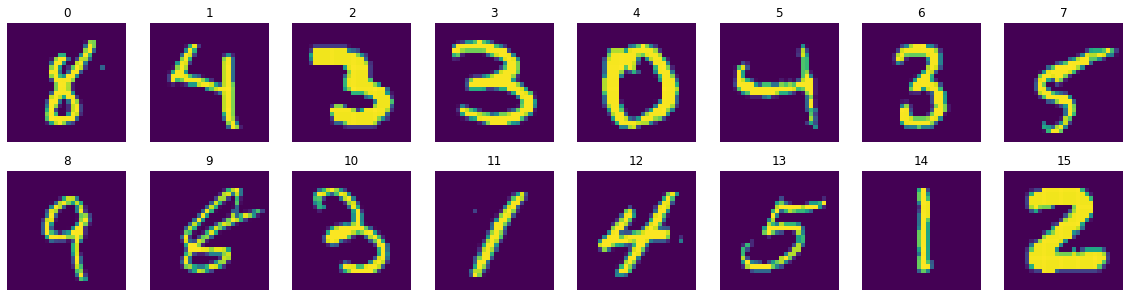

In [8]:
for batch in dl_train:
    print(batch[0][0].min(), batch[0][0].max())
    print(batch[0].shape)
    I.wrap(batch[0], batch[1]).normalize().show(cols=8)
    break

  0%|          | 0/1 [00:00<?, ?it/s]

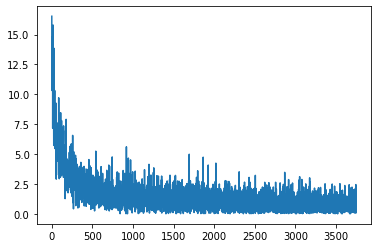

In [9]:
epochs = 1
lr = 0.05
weights = torch.randn(28*28, 10).float().to(device)
bias = torch.randn(10).float().to(device)

weights.requires_grad_()
bias.requires_grad_()

losses = []

for epoch in tqdm(range(epochs)):
    for batch in dl_train:
        batch_size = len(batch[0])
        x = batch[0].to(device).reshape(batch_size, -1)
        targets = batch[1].to(device)
        
        if weights.grad is not None:
            weights.grad.zero_()
            bias.grad.zero_()
        
        yhat = x@weights + bias
        loss = F.cross_entropy(yhat, targets)
        losses.append(loss.item())
        
        loss.backward()
        
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
        
        
plt.plot(losses)

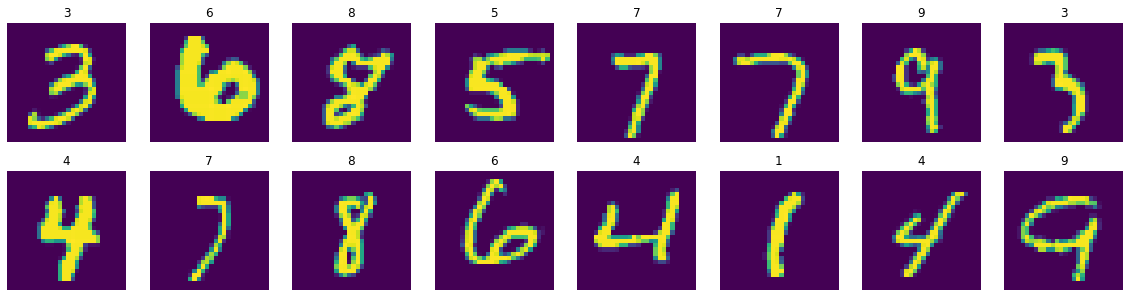

In [10]:
## Check accuracy
I.wrap(*first_batch).show(cols=8)

In [11]:
with torch.no_grad():
    batch_size = len(first_batch[0])
    pred = first_batch[0].reshape(batch_size, -1).to(device) @ weights + bias
    pred = pred.detach().cpu()
    
pred_labels = torch.argmax(pred, dim=-1)
pred_labels, first_batch[1]

(tensor([3, 6, 7, 5, 7, 7, 9, 3, 4, 9, 1, 6, 4, 8, 4, 9]),
 tensor([3, 6, 8, 5, 7, 7, 9, 3, 4, 7, 8, 6, 4, 1, 4, 9]))

In [12]:
accuracy = (pred_labels == first_batch[1]).sum() / batch_size * 100
accuracy

tensor(75.)

In [13]:
def calc_accuracy(images, labels):
    batch_size = len(images)
    pred = images.reshape(batch_size, -1).to(device) @ weights + bias
    pred = pred.detach().cpu()
    
    pred_labels = torch.argmax(pred, dim=-1)
    accuracy = (pred_labels == labels).sum() / batch_size * 100
    
    return accuracy

calc_accuracy(*first_batch)

tensor(75.)

## Let's Rerun with the Accuracy Plots

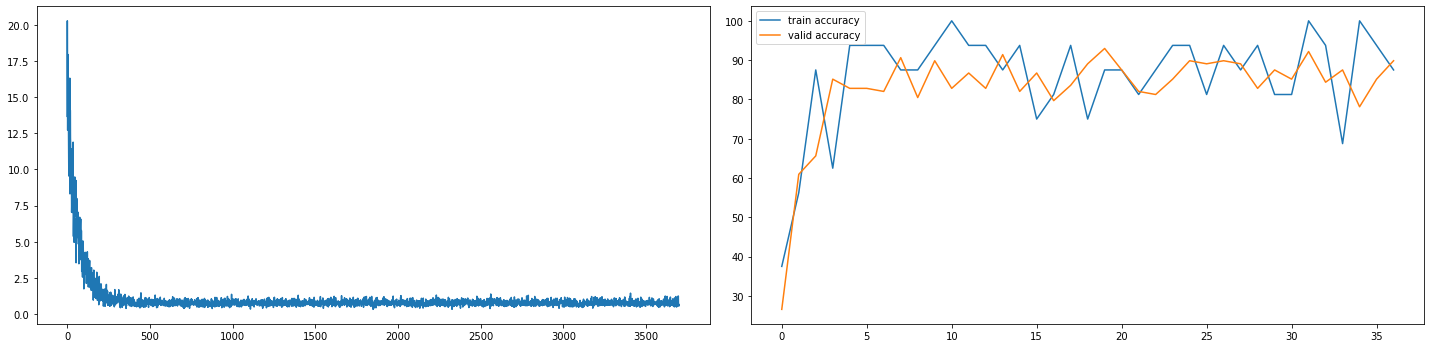

  0%|          | 0/3750 [00:00<?, ?it/s]

In [14]:
epochs = 1
lr = 0.05
weights = torch.randn(28*28, 10).float().to(device)
bias = torch.randn(10).float().to(device)

optimizer = torch.optim.SGD([weights, bias], lr=lr, weight_decay=0.1)

weights.requires_grad_()
bias.requires_grad_()

losses = []
accuracy_list = []
valid_accuracy_list = []
i = 0

lp = I.live_plot(2)

for epoch in range(epochs):
    for batch in tqdm(dl_train):
        i += 1
        batch_size = len(batch[0])
        x = batch[0].to(device).reshape(batch_size, -1)
        targets = batch[1].to(device)
        
        optimizer.zero_grad()
        
        yhat = x@weights + bias
        loss = F.cross_entropy(yhat, targets)        
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
            
        if i % 100 == 0:
            
            accuracy_list.append(calc_accuracy(*batch).item())
            
            valid_batch = next(iter(torch.utils.data.DataLoader(ds_valid, shuffle=True, batch_size=128)))
            valid_accuracy_list.append(calc_accuracy(*valid_batch).item())
            
            lp.plot(0, losses)
            lp.plot(1, accuracy_list, label="train accuracy")
            lp.plot(1, valid_accuracy_list, label="valid accuracy")
            lp.update()
               
lp.close()

In [15]:
torch.tensor(valid_accuracy_list[-10:]).mean()

tensor(86.1719)

In [16]:
# claculate overall valid accuracy
dl = torch.utils.data.DataLoader(ds_valid, batch_size=64)
accuracy_list = []
for batch in tqdm(dl):
    accuracy_list.append(calc_accuracy(*batch).item())
    
valid_accuracy = torch.tensor(accuracy_list).mean().item()
valid_accuracy

  0%|          | 0/157 [00:00<?, ?it/s]

85.74840545654297

## Let's Try to Run Couple of More Epochs

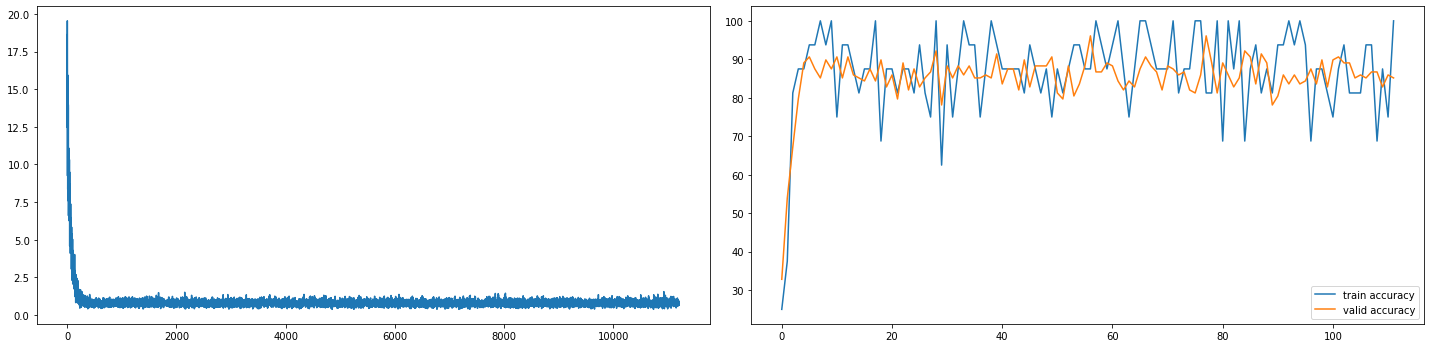

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

  0%|          | 0/3750 [00:00<?, ?it/s]

In [17]:
epochs = 3
lr = 0.05
weights = torch.randn(28*28, 10).float().to(device)
bias = torch.randn(10).float().to(device)

optimizer = torch.optim.SGD([weights, bias], lr=lr, weight_decay=0.1)

weights.requires_grad_()
bias.requires_grad_()

losses = []
accuracy_list = []
valid_accuracy_list = []
i = 0

lp = I.live_plot(2)

for epoch in range(epochs):
    for batch in tqdm(dl_train):
        i += 1
        batch_size = len(batch[0])
        x = batch[0].to(device).reshape(batch_size, -1)
        targets = batch[1].to(device)
        
        optimizer.zero_grad()
        
        yhat = x@weights + bias
        loss = F.cross_entropy(yhat, targets)        
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
            
        if i % 100 == 0:
            
            accuracy_list.append(calc_accuracy(*batch).item())
            
            valid_batch = next(iter(torch.utils.data.DataLoader(ds_valid, shuffle=True, batch_size=128)))
            valid_accuracy_list.append(calc_accuracy(*valid_batch).item())
            
            lp.plot(0, losses)
            lp.plot(1, accuracy_list, label="train accuracy")
            lp.plot(1, valid_accuracy_list, label="valid accuracy")
            lp.update()
               
lp.close()

In [18]:
# let's calculate the accuracy again

dl = torch.utils.data.DataLoader(ds_valid, batch_size=64)
accuracy_list = []
for batch in tqdm(dl):
    accuracy_list.append(calc_accuracy(*batch).item())
    
valid_accuracy = torch.tensor(accuracy_list).mean().item()
valid_accuracy

  0%|          | 0/157 [00:00<?, ?it/s]

85.80812072753906

## Conclusion

Running more epoches wont' help in this case.
<br/>
That's because our linear model cannot learn more.